In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 3a - Coupled 2-box with vertical diffusion

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [91]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 2

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, exp in enumerate(experiments):
  full_outputs[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i,vert_diff_flag=1)
  forcings[exp] = np.tile(full_outputs[exp]['forcing_ts'], (n_boxes, 1))
  T_out[exp] = np.squeeze(full_outputs[exp]['T_ts'])[0:n_boxes,:]

for exp in experiments:
  forcings[exp][1] = np.zeros(len(forcings[exp][1]))

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method X: DMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.01174056126659643
	Test: High Emissions - 0.3129948808417992
	Test: Overshoot - 0.16526381062139184
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.6070566287407358
	Test: High Emissions - 0.00018437475070408606
	Test: Overshoot - 0.2944270587277676
Train: Overshoot - L2 Error
	Test: 2xCO2 - 0.37750848925034286
	Test: High Emissions - 0.008980855964325728
	Test: Overshoot - 0.0022749107426856697


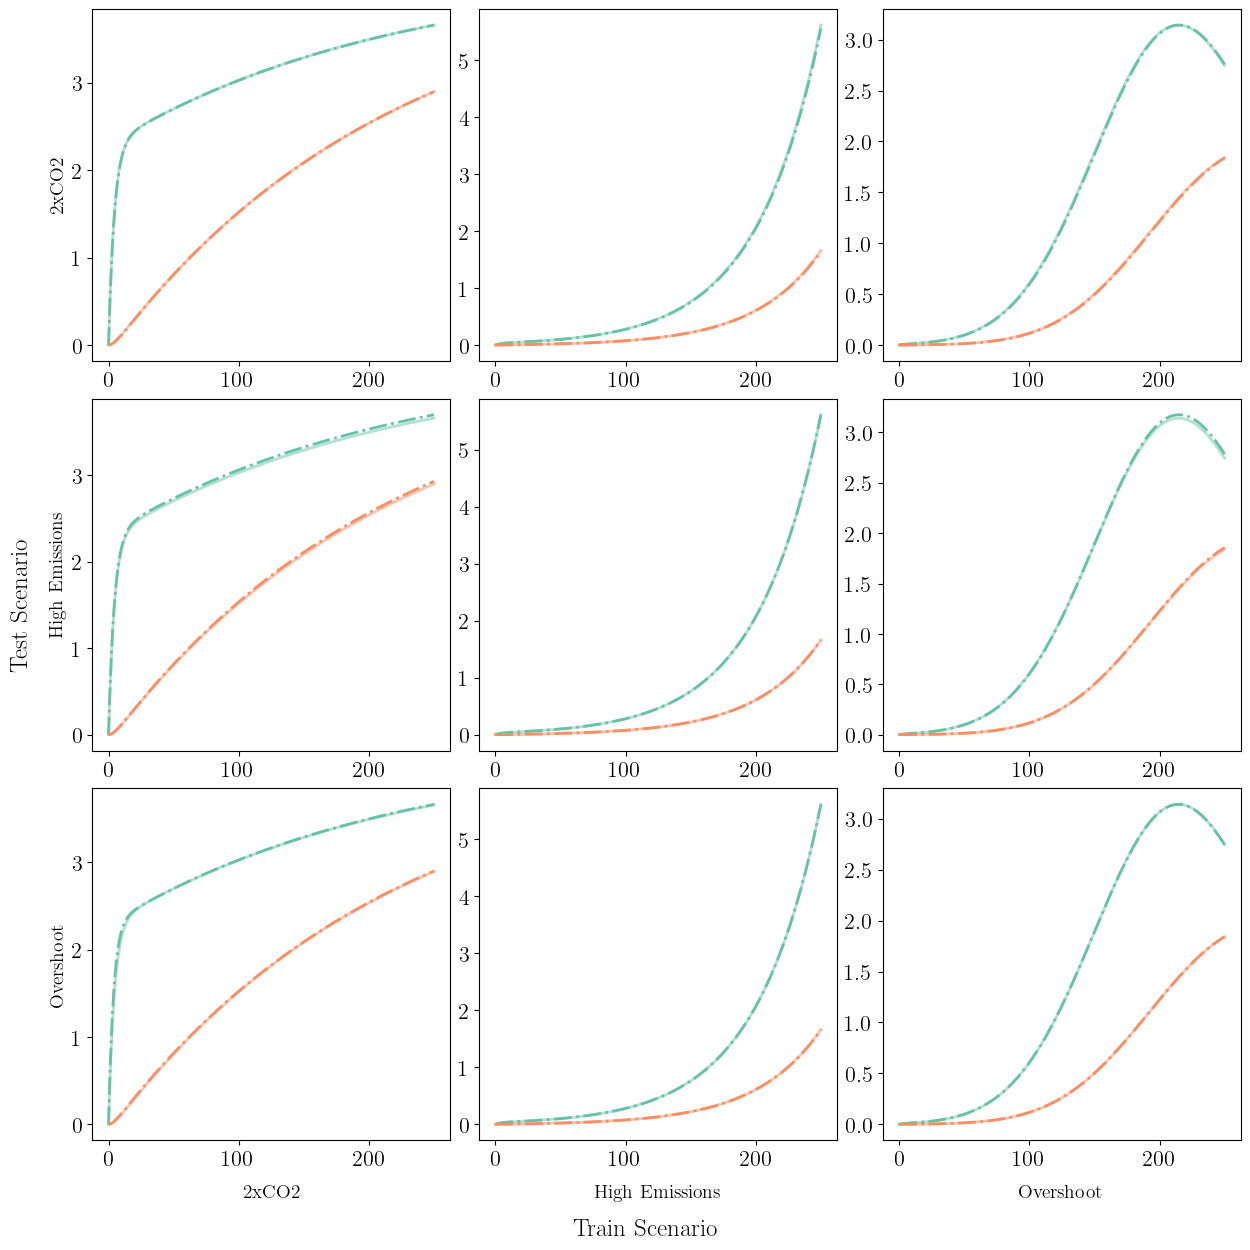

In [92]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out, forcings=forcings, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_DMD, experiments)

### Method X: EDMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.0006694284467059111
	Test: High Emissions - 2.8279702812448226
	Test: Overshoot - 2.704885999942558
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.784117235211878
	Test: High Emissions - 2.290230561763539e-05
	Test: Overshoot - 0.790343035690092
Train: Overshoot - L2 Error
	Test: 2xCO2 - 0.5064034303080819
	Test: High Emissions - 0.5946935616195355
	Test: Overshoot - 0.003326597120141108


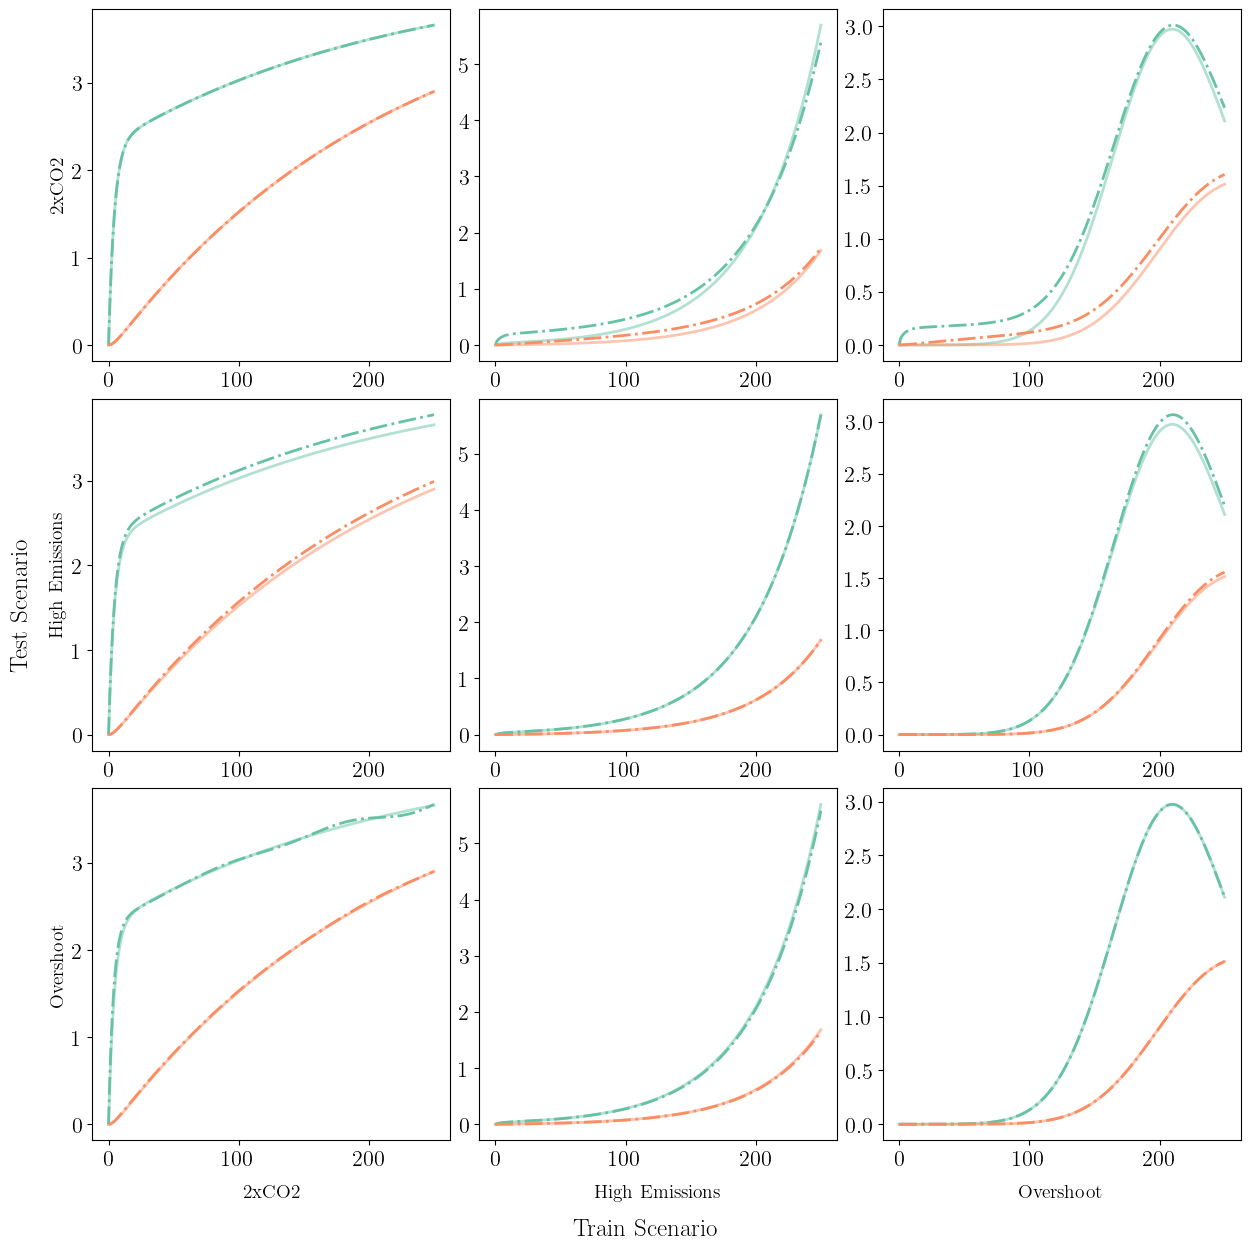

In [130]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
operator_EDMD, T_pred_EDMD = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'EDMD', w0, t, dt, n_steps, n_boxes, w_dict, F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, experiments)

### Method X: Deconvolution

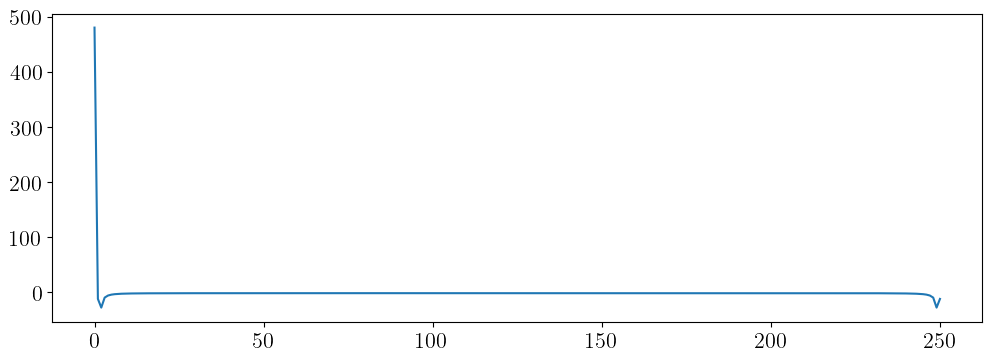

In [99]:
#plt.plot(operator_deconvolve['High Emissions'].T)
#plt.plot(operator_direct.T)
#plt.plot(G1.T)
#plt.plot(G3.T[:,0])
#plt.plot(G4.T[:,0])
plt.plot(np.fft.fft(F1[0,:]).T)

In [94]:
from scipy import sparse
from scipy.linalg import toeplitz
from scipy.sparse.linalg import spsolve_triangular
F_toep = sparse.csr_matrix(toeplitz(F1[0,:], np.zeros_like(F1[0,:])))
np.linalg.cond(F_toep.toarray())

np.float64(45655.17094465652)

In [93]:
dt = 1
exp = 'Overshoot'
w1, w2 = T_out[exp], T_out[exp][:,100:200]
F1, F2 = forcings[exp], forcings[exp][:,100:200]
G1 = emulator_utils.method_3a_deconvolve(w1, F1, dt, regularize=False)
G2 = emulator_utils.method_3a_deconvolve(w1, F1, dt, regularize=True)
G3 = emulator_utils.method_3a_deconvolve(w2, F2, dt, regularize=False)
G4 = emulator_utils.method_3a_deconvolve(w2, F2, dt, regularize=True)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 2.5700432227947362e-14
	Test: High Emissions - 0.30465557178819325
	Test: Overshoot - 0.18684398098440974
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.5938969151638678
	Test: High Emissions - 2.1959045202441585e-14
	Test: Overshoot - 0.2801299148812935
Train: Overshoot - L2 Error
	Test: 2xCO2 - 388883.3389637226
	Test: High Emissions - 6252.852543361017
	Test: Overshoot - 2.5362765584796365e-14


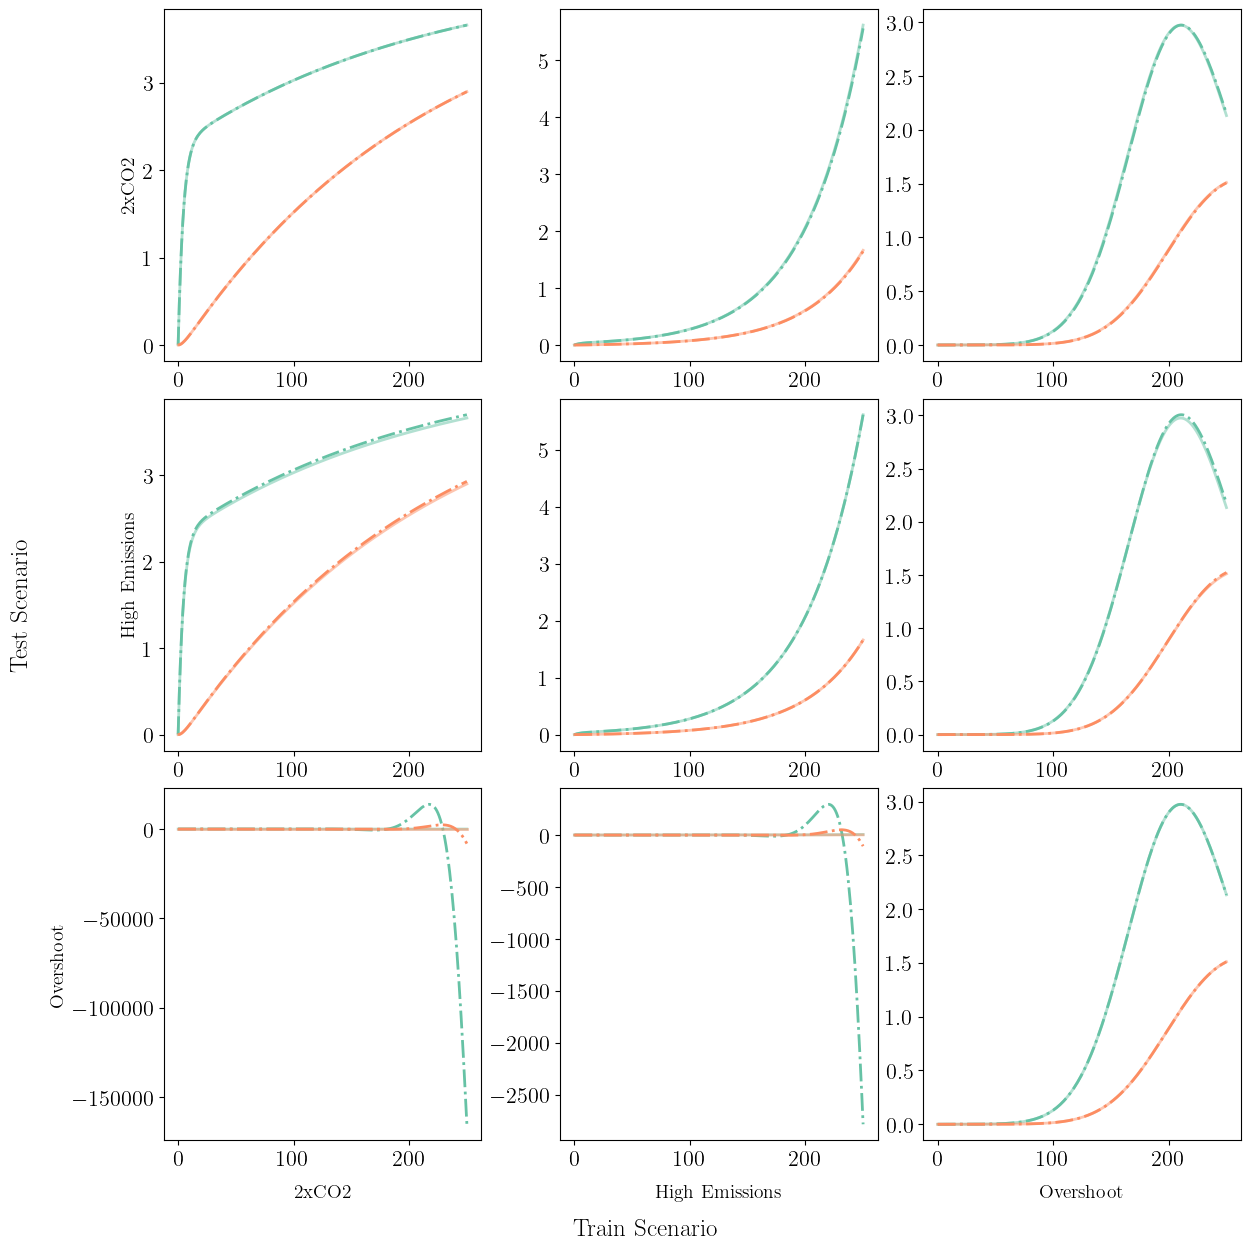

In [26]:
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out, forcings=forcings, dt=dt)
emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)

### Method X: Direct Diagnosis (FDT)

Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 0.6717488726590547
	Test: High Emissions - 0.0473128657814982
	Test: Overshoot - 0.31360235667165576


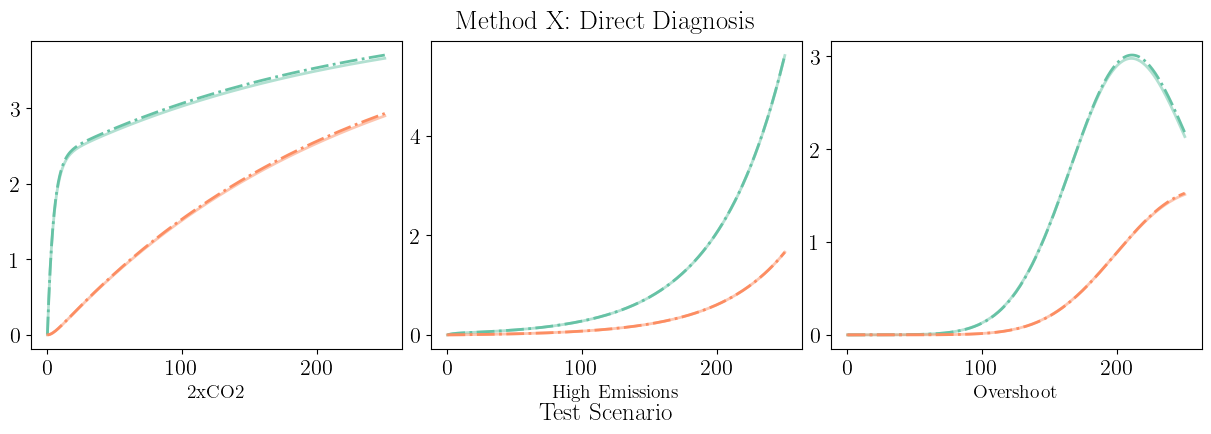

In [30]:
operator_direct, T_pred_direct, L2_direct = emulator_utils.emulate_experiments('direct', experiments=experiments, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, vert_diff_flag=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [ 0.5636958   0.39960492 -0.00294101  0.74566847 -0.99627297 -0.00446863]
	Test: 2xCO2 - 2.2058598326210728
	Test: High Emissions - 0.29559612183917644
	Test: Overshoot - 0.8131601208684512
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.7160171   0.64643324  0.50710256 -2.2682105  -0.83465376 -1.2354605 ]
	Test: 2xCO2 - 22.239134038800238
	Test: High Emissions - 0.13195308078342752
	Test: Overshoot - 5.690631935597779
Train: Overshoot - L2 Error
Exponential Fit Results:
 [-5.45969057e+02 -6.57386505e+02  3.69119260e+02  6.51290178e+02
 -6.86816558e-01 -6.30948158e-01]
	Test: 2xCO2 - 19.583458024997356
	Test: High Emissions - 2.5847908171773786
	Test: Overshoot - 5.1948820809057725


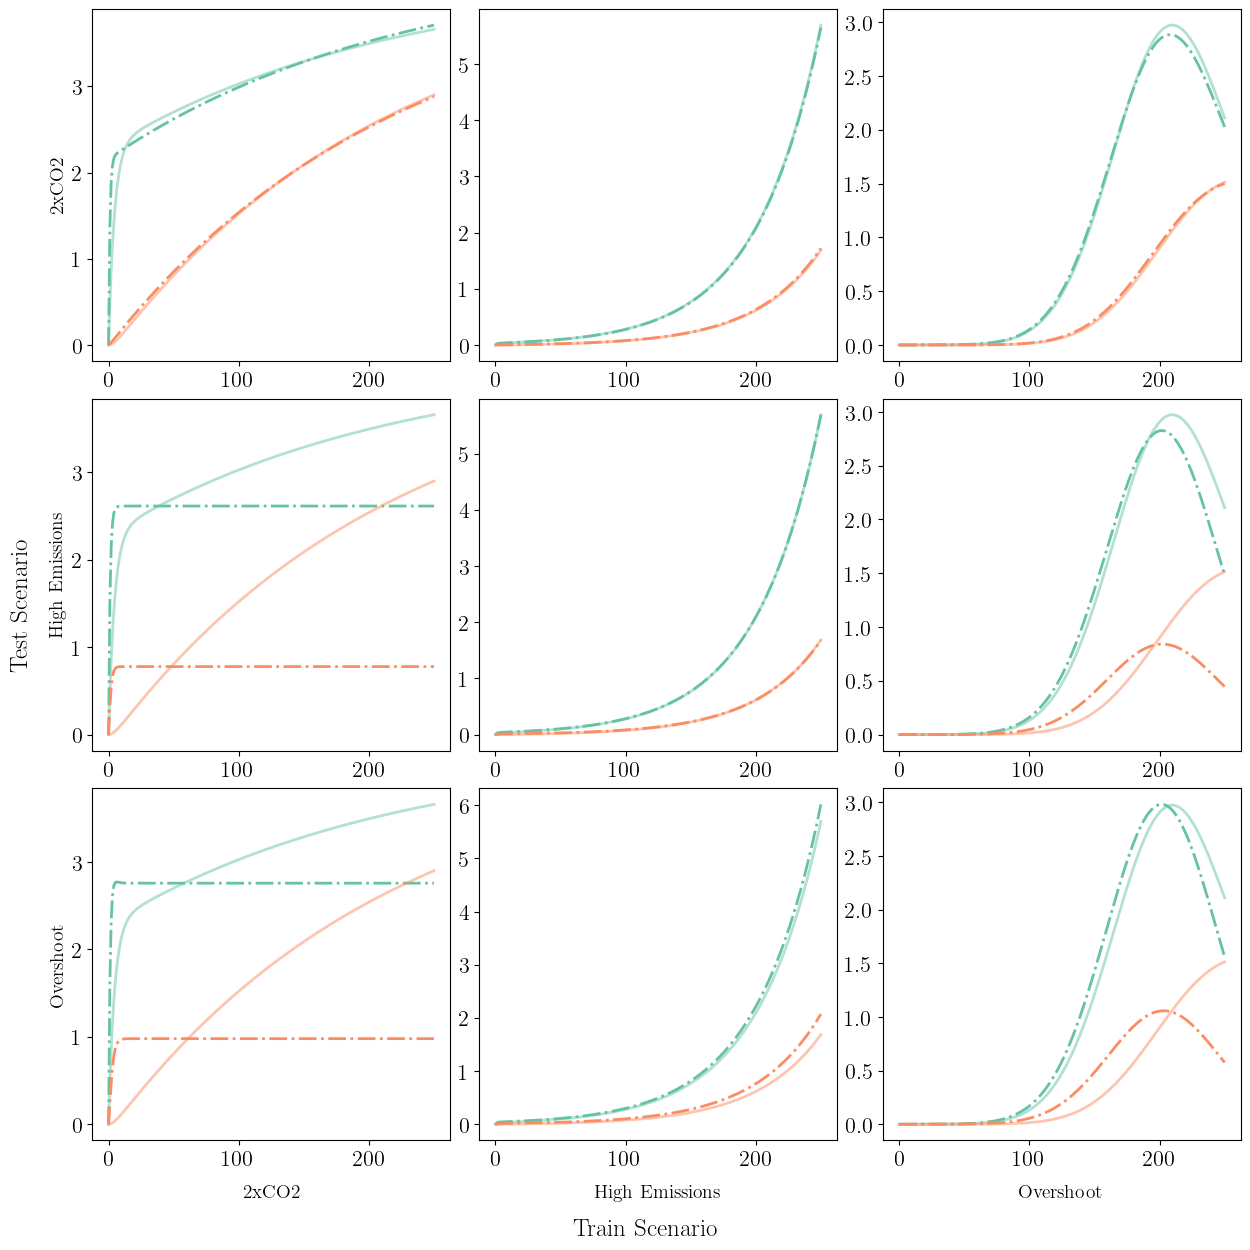

In [132]:
B=np.array([1.0, 0.0])
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2, B=B)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)